### 0. Initizalize Packages

In [5]:
#!pip install scipy,seaborn
import seaborn as sns
from scipy.stats import kstest

import pandas as pd
import numpy as np

#!pip install -U plotly
pd.options.plotting.backend = "plotly"

#!pip3 install nltk
import nltk
from nltk import pos_tag
from nltk import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from nltk.tokenize import word_tokenize, sent_tokenize
from scipy.stats import chi2_contingency

import math
from scipy.stats import shapiro 
from scipy.stats import lognorm
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt

#!pip3 install openpyxl
import openpyxl as px
from statsmodels.stats.weightstats import ztest



### 0.1. Read Dataset ( N = 114)

In [49]:
df = pd.read_excel('all_gpt_human_only_text.xlsx')

### 0.1.1 Preprocess

Get rid of extra white spaces

In [50]:
def strip(dataframe):
    return [s.strip() for s in dataframe]

df= df.apply(strip)

## 1. Pos Tagging with Less Category Separate for Each Sentence

Each story's pos taggings completed separately, and counted for the story itself

### 1.1. Preprocess and Tag

In [51]:
#clean data from stopwords, tokenize it, and tag
punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
stop_words = set(stopwords.words('english'))

def create_tokenized(text):
    tokenized = word_tokenize(text)
    tokenized_no_punc = [w.lower() for w in tokenized if w not in punc]
    filtered = [w for w in tokenized_no_punc]# if w not in stop_words]
    tagged = nltk.pos_tag(filtered)
    return tagged

In [52]:
## Filter and get words as tokens
for column in df.columns:
    df[f'tokenized_{column}'] = df[column].apply(lambda x: create_tokenized(x))

### 1.2. Count the pos-tags

In [53]:
df.columns

Index(['STORY', 'GPT_R1', 'GPT_R2', 'GPT_R3', 'Retell_1', 'Retell_2',
       'Retell_3', 'tokenized_STORY', 'tokenized_GPT_R1', 'tokenized_GPT_R2',
       'tokenized_GPT_R3', 'tokenized_Retell_1', 'tokenized_Retell_2',
       'tokenized_Retell_3'],
      dtype='object')

In [54]:
#count the tags
def count_tags(mydata):
    counter_list=[]
    for i in mydata:
        counter_list.append(i[1])

    tag_counts = Counter(counter_list) 
    return tag_counts

In [55]:
for column in [col for col in df.columns if col.startswith('tokenized_')]:
    df[f'{column}_tag_counts'] = df[column].apply(lambda x: count_tags(x))

In [56]:
df.columns

Index(['STORY', 'GPT_R1', 'GPT_R2', 'GPT_R3', 'Retell_1', 'Retell_2',
       'Retell_3', 'tokenized_STORY', 'tokenized_GPT_R1', 'tokenized_GPT_R2',
       'tokenized_GPT_R3', 'tokenized_Retell_1', 'tokenized_Retell_2',
       'tokenized_Retell_3', 'tokenized_STORY_tag_counts',
       'tokenized_GPT_R1_tag_counts', 'tokenized_GPT_R2_tag_counts',
       'tokenized_GPT_R3_tag_counts', 'tokenized_Retell_1_tag_counts',
       'tokenized_Retell_2_tag_counts', 'tokenized_Retell_3_tag_counts'],
      dtype='object')

In [57]:
df.tokenized_STORY_tag_counts

0      {'DT': 16, 'NN': 25, 'WP': 3, 'VBD': 11, 'IN':...
1      {'NN': 23, 'VBD': 14, 'VBG': 7, 'JJ': 8, 'CD':...
2      {'DT': 20, 'NN': 28, 'VBD': 17, 'TO': 7, 'VB':...
3      {'DT': 14, 'IN': 15, 'PRP$': 2, 'NN': 22, 'VBD...
4      {'VB': 6, 'PRP': 17, 'RB': 9, 'VBD': 17, 'DT':...
                             ...                        
111    {'NN': 35, 'VBZ': 4, 'PRP$': 6, '``': 11, 'VB'...
112    {'RB': 10, 'EX': 1, 'VBD': 20, 'DT': 31, 'NN':...
113    {'EX': 1, 'VBD': 18, 'DT': 20, 'NN': 32, 'WP':...
114    {'CD': 1, 'NN': 30, 'DT': 18, 'VBD': 13, 'VBG'...
115    {'DT': 15, 'NN': 24, 'VBD': 12, 'RB': 11, 'IN'...
Name: tokenized_STORY_tag_counts, Length: 116, dtype: object

### 1.3. Merge relevant categories together

Count tags for all nouns (plural nouns, proper nouns etc.), verbs, adjectives, adverbs, pronouns and prepositions/conjuctions/determiners


In [ ]:
for column in [col for col in df.columns if col.endswith('tag_counts')]:
    df[f'{column[:-7]}_noun'] = [*(df[column].apply(lambda x: (x['NN'] + x['NNS'] + x['NNP']+ x['NNPS'])))]
    df[f'{column[:-7]}_verb'] = [*(df[column].apply(lambda x: (x['VB'] + x['VBN'] + x['VBG']+ x['VBZ'] + x['VBP']+x['VBD'])))]
    df[f'{column[:-7]}_adj'] = [*(df[column].apply(lambda x: (x['JJ'] + x['JJS'] + x['JJR'])))]
    df[f'{column[:-7]}_adv'] = [*(df[column].apply(lambda x: (x['RB'] + x['RBR'] + x['WBR'])))]
    df[f'{column[:-7]}_pron'] = [*(df[column].apply(lambda x: (x['PRP'] + x['PRP$'] + x['WB']+ x['WB$'])))]
    df[f'{column[:-7]}_con_det_prep'] = [*(df[column].apply(lambda x: (x['DT'] + x['IN'] + x['UH']+ x['TO']+ x['WDT']+ x['EX'])))]
    df[f'{column[:-7]}_prep'] = [*(df[column].apply(lambda x: (x['IN'])))]



In [ ]:
df['tokenized_GPT_R3'].apply(lambda x: len(x))
df.tokenized_GPT_R3_tag_noun

## 1.4. Get Ratio of Grammatical Categories to Word Count

In [ ]:
#Nouns
df['GPT_3_noun_ratio'] = (df.tokenized_GPT_R3_tag_noun / (df['tokenized_GPT_R3'].apply(lambda x: len(x))))
df['GPT_2_noun_ratio'] = (df.tokenized_GPT_R2_tag_noun / (df['tokenized_GPT_R2'].apply(lambda x: len(x))))
df['GPT_1_noun_ratio'] = (df.tokenized_GPT_R1_tag_noun / (df['tokenized_GPT_R1'].apply(lambda x: len(x))))

df['Retell_1_noun_ratio'] = (df.tokenized_Retell_1_tag_noun / (df['tokenized_Retell_1'].apply(lambda x: len(x))))
df['Retell_2_noun_ratio'] = (df.tokenized_Retell_2_tag_noun / (df['tokenized_Retell_2'].apply(lambda x: len(x))))
df['Retell_3_noun_ratio'] = (df.tokenized_Retell_3_tag_noun / (df['tokenized_Retell_3'].apply(lambda x: len(x))))

df['story_noun_ratio'] = (df.tokenized_STORY_tag_noun / (df['tokenized_STORY'].apply(lambda x: len(x))))


#Verbs
df['GPT_3_verb_ratio'] = (df.tokenized_GPT_R3_tag_verb / (df['tokenized_GPT_R3'].apply(lambda x: len(x))))
df['GPT_2_verb_ratio'] = (df.tokenized_GPT_R2_tag_verb / (df['tokenized_GPT_R2'].apply(lambda x: len(x))))
df['GPT_1_verb_ratio'] = (df.tokenized_GPT_R1_tag_verb / (df['tokenized_GPT_R1'].apply(lambda x: len(x))))

df['Retell_1_verb_ratio'] = (df.tokenized_Retell_1_tag_verb / (df['tokenized_Retell_1'].apply(lambda x: len(x))))
df['Retell_2_verb_ratio'] = (df.tokenized_Retell_2_tag_verb / (df['tokenized_Retell_2'].apply(lambda x: len(x))))
df['Retell_3_verb_ratio'] = (df.tokenized_Retell_3_tag_verb / (df['tokenized_Retell_3'].apply(lambda x: len(x))))

df['story_verb_ratio'] = (df.tokenized_STORY_tag_verb / (df['tokenized_STORY'].apply(lambda x: len(x))))

#Adj 
df['GPT_3_adj_ratio'] = (df.tokenized_GPT_R3_tag_adj / (df['tokenized_GPT_R3'].apply(lambda x: len(x))))
df['GPT_2_adj_ratio'] = (df.tokenized_GPT_R2_tag_adj / (df['tokenized_GPT_R2'].apply(lambda x: len(x))))
df['GPT_1_adj_ratio'] = (df.tokenized_GPT_R1_tag_adj / (df['tokenized_GPT_R1'].apply(lambda x: len(x))))

df['Retell_1_adj_ratio'] = (df.tokenized_Retell_1_tag_adj / (df['tokenized_Retell_1'].apply(lambda x: len(x))))
df['Retell_2_adj_ratio'] = (df.tokenized_Retell_2_tag_adj / (df['tokenized_Retell_2'].apply(lambda x: len(x))))
df['Retell_3_adj_ratio'] = (df.tokenized_Retell_3_tag_adj / (df['tokenized_Retell_3'].apply(lambda x: len(x))))

df['story_adj_ratio'] = (df.tokenized_STORY_tag_adj / (df['tokenized_STORY'].apply(lambda x: len(x))))

#Adv
df['GPT_3_adv_ratio'] = (df.tokenized_GPT_R3_tag_adv / (df['tokenized_GPT_R3'].apply(lambda x: len(x))))
df['GPT_2_adv_ratio'] = (df.tokenized_GPT_R2_tag_adv / (df['tokenized_GPT_R2'].apply(lambda x: len(x))))
df['GPT_1_adv_ratio'] = (df.tokenized_GPT_R1_tag_adv / (df['tokenized_GPT_R1'].apply(lambda x: len(x))))

df['Retell_1_adv_ratio'] = (df.tokenized_Retell_1_tag_adv / (df['tokenized_Retell_1'].apply(lambda x: len(x))))
df['Retell_2_adv_ratio'] = (df.tokenized_Retell_2_tag_adv / (df['tokenized_Retell_2'].apply(lambda x: len(x))))
df['Retell_3_adv_ratio'] = (df.tokenized_Retell_3_tag_adv / (df['tokenized_Retell_3'].apply(lambda x: len(x))))

df['story_adv_ratio'] = (df.tokenized_STORY_tag_adv / (df['tokenized_STORY'].apply(lambda x: len(x))))


#Prep_con_det
df['GPT_3_con_det_prep_ratio'] = (df.tokenized_GPT_R3_tag_con_det_prep / (df['tokenized_GPT_R3'].apply(lambda x: len(x))))
df['GPT_2_con_det_prep_ratio'] = (df.tokenized_GPT_R2_tag_con_det_prep / (df['tokenized_GPT_R2'].apply(lambda x: len(x))))
df['GPT_1_con_det_prep_ratio'] = (df.tokenized_GPT_R1_tag_con_det_prep / (df['tokenized_GPT_R1'].apply(lambda x: len(x))))

df['Retell_1_con_det_prep_ratio'] = (df.tokenized_Retell_1_tag_con_det_prep / (df['tokenized_Retell_1'].apply(lambda x: len(x))))
df['Retell_2_con_det_prep_ratio'] = (df.tokenized_Retell_2_tag_con_det_prep / (df['tokenized_Retell_2'].apply(lambda x: len(x))))
df['Retell_3_con_det_prep_ratio'] = (df.tokenized_Retell_3_tag_con_det_prep / (df['tokenized_Retell_3'].apply(lambda x: len(x))))

df['story_con_det_prep_ratio'] = (df.tokenized_STORY_tag_con_det_prep / (df['tokenized_STORY'].apply(lambda x: len(x))))


#pron
df['GPT_3_pron_ratio'] = (df.tokenized_GPT_R3_tag_pron / (df['tokenized_GPT_R3'].apply(lambda x: len(x))))
df['GPT_2_pron_ratio'] = (df.tokenized_GPT_R2_tag_pron / (df['tokenized_GPT_R2'].apply(lambda x: len(x))))
df['GPT_1_pron_ratio'] = (df.tokenized_GPT_R1_tag_pron / (df['tokenized_GPT_R1'].apply(lambda x: len(x))))

df['Retell_1_pron_ratio'] = (df.tokenized_Retell_1_tag_pron / (df['tokenized_Retell_1'].apply(lambda x: len(x))))
df['Retell_2_pron_ratio'] = (df.tokenized_Retell_2_tag_pron / (df['tokenized_Retell_2'].apply(lambda x: len(x))))
df['Retell_3_pron_ratio'] = (df.tokenized_Retell_3_tag_pron / (df['tokenized_Retell_3'].apply(lambda x: len(x))))

df['story_pron_ratio'] = (df.tokenized_STORY_tag_pron / (df['tokenized_STORY'].apply(lambda x: len(x))))

#Prep
df['GPT_3_prep_ratio'] = (df.tokenized_GPT_R3_tag_prep / (df['tokenized_GPT_R3'].apply(lambda x: len(x))))
df['GPT_2_prep_ratio'] = (df.tokenized_GPT_R2_tag_prep / (df['tokenized_GPT_R2'].apply(lambda x: len(x))))
df['GPT_1_prep_ratio'] = (df.tokenized_GPT_R1_tag_prep / (df['tokenized_GPT_R1'].apply(lambda x: len(x))))

df['Retell_1_prep_ratio'] = (df.tokenized_Retell_1_tag_prep / (df['tokenized_Retell_1'].apply(lambda x: len(x))))
df['Retell_2_prep_ratio'] = (df.tokenized_Retell_2_tag_prep / (df['tokenized_Retell_2'].apply(lambda x: len(x))))
df['Retell_3_prep_ratio'] = (df.tokenized_Retell_3_tag_prep / (df['tokenized_Retell_3'].apply(lambda x: len(x))))

df['story_prep_ratio'] = (df.tokenized_STORY_tag_prep / (df['tokenized_STORY'].apply(lambda x: len(x))))

### 1.4.1. Carry counts and ratios into different DataFrame

In [ ]:
count_ratio = pd.DataFrame

count_ratio= df[['GPT_3_noun_ratio',
 'GPT_2_noun_ratio',
 'GPT_1_noun_ratio',
 'Retell_1_noun_ratio',
 'Retell_2_noun_ratio',
 'Retell_3_noun_ratio',
 'story_noun_ratio',
 'GPT_3_verb_ratio',
 'GPT_2_verb_ratio',
 'GPT_1_verb_ratio',
 'Retell_1_verb_ratio',
 'Retell_2_verb_ratio',
 'Retell_3_verb_ratio',
 'story_verb_ratio',
 'GPT_3_adj_ratio',
 'GPT_2_adj_ratio',
 'GPT_1_adj_ratio',
 'Retell_1_adj_ratio',
 'Retell_2_adj_ratio',
 'Retell_3_adj_ratio',
 'story_adj_ratio',
 'GPT_3_adv_ratio',
 'GPT_2_adv_ratio',
 'GPT_1_adv_ratio',
 'Retell_1_adv_ratio',
 'Retell_2_adv_ratio',
 'Retell_3_adv_ratio',
 'story_adv_ratio',
 'GPT_3_con_det_prep_ratio',
 'GPT_2_con_det_prep_ratio',
 'GPT_1_con_det_prep_ratio',
 'Retell_1_con_det_prep_ratio',
 'Retell_2_con_det_prep_ratio',
 'Retell_3_con_det_prep_ratio',
 'story_con_det_prep_ratio',
 'GPT_3_pron_ratio',
 'GPT_2_pron_ratio',
 'GPT_1_pron_ratio',
 'Retell_1_pron_ratio',
 'Retell_2_pron_ratio',
 'Retell_3_pron_ratio',
 'story_pron_ratio',
 'GPT_3_prep_ratio',
 'GPT_2_prep_ratio',
 'GPT_1_prep_ratio',
 'Retell_1_prep_ratio',
 'Retell_2_prep_ratio',
 'Retell_3_prep_ratio',
 'story_prep_ratio']]

In [13]:
#store counts into a dataframe 
counts = pd.DataFrame()

df_count = df[['tokenized_STORY_tag_noun',
 'tokenized_STORY_tag_verb',
 'tokenized_STORY_tag_adj',
 'tokenized_STORY_tag_adv',
 'tokenized_STORY_tag_pron',
 'tokenized_STORY_tag_con_det_prep',
 'tokenized_STORY_tag_prep',
 'tokenized_GPT_R1_tag_noun',
 'tokenized_GPT_R1_tag_verb',
 'tokenized_GPT_R1_tag_adj',
 'tokenized_GPT_R1_tag_adv',
 'tokenized_GPT_R1_tag_pron',
 'tokenized_GPT_R1_tag_con_det_prep',
 'tokenized_GPT_R1_tag_prep',
 'tokenized_GPT_R2_tag_noun',
 'tokenized_GPT_R2_tag_verb',
 'tokenized_GPT_R2_tag_adj',
 'tokenized_GPT_R2_tag_adv',
 'tokenized_GPT_R2_tag_pron',
 'tokenized_GPT_R2_tag_con_det_prep',
 'tokenized_GPT_R2_tag_prep',
 'tokenized_GPT_R3_tag_noun',
 'tokenized_GPT_R3_tag_verb',
 'tokenized_GPT_R3_tag_adj',
 'tokenized_GPT_R3_tag_adv',
 'tokenized_GPT_R3_tag_pron',
 'tokenized_GPT_R3_tag_con_det_prep',
 'tokenized_GPT_R3_tag_prep',
 'tokenized_Retell_1_tag_noun',
 'tokenized_Retell_1_tag_verb',
 'tokenized_Retell_1_tag_adj',
 'tokenized_Retell_1_tag_adv',
 'tokenized_Retell_1_tag_pron',
 'tokenized_Retell_1_tag_con_det_prep',
 'tokenized_Retell_1_tag_prep',
 'tokenized_Retell_2_tag_noun',
 'tokenized_Retell_2_tag_verb',
 'tokenized_Retell_2_tag_adj',
 'tokenized_Retell_2_tag_adv',
 'tokenized_Retell_2_tag_pron',
 'tokenized_Retell_2_tag_con_det_prep',
 'tokenized_Retell_2_tag_prep',
 'tokenized_Retell_3_tag_noun',
 'tokenized_Retell_3_tag_verb',
 'tokenized_Retell_3_tag_adj',
 'tokenized_Retell_3_tag_adv',
 'tokenized_Retell_3_tag_pron',
 'tokenized_Retell_3_tag_con_det_prep',
 'tokenized_Retell_3_tag_prep']

]

Our dataframes are:

1-count = df_count
2- ratio = count_ratio

### 1.5. Significance Test Between Retellings (Counts of Words)

In [ ]:
mannwhitneyu(df_count['tokenized_GPT_R3_tag_con_det_prep'], df_count['tokenized_Retell_3_tag_con_det_prep']) #significant

In [ ]:
shapiro(df_count) #data is not normal, so we will use Mann-u Whitney

In [ ]:

shapiro(df_count) #data is not normal, so we will use Mann-u Whitney

#Nouns
mannwhitneyu(df_count['tokenized_GPT_R1_tag_noun'], df_count['tokenized_Retell_1_tag_noun']) #significant
mannwhitneyu(df_count['tokenized_GPT_R2_tag_noun'], df_count['tokenized_Retell_2_tag_noun'])
mannwhitneyu(df_count['tokenized_GPT_R3_tag_noun'], df_count['tokenized_Retell_3_tag_noun']) #significant

#Verbs
mannwhitneyu(df_count['tokenized_GPT_R1_tag_verb'], df_count['tokenized_Retell_1_tag_verb']) #significant
mannwhitneyu(df_count['tokenized_GPT_R2_tag_verb'], df_count['tokenized_Retell_2_tag_verb']) #significant
mannwhitneyu(df_count['tokenized_GPT_R3_tag_verb'], df_count['tokenized_Retell_3_tag_verb']) #significant

#Adjectives
mannwhitneyu(df_count['tokenized_GPT_R1_tag_adj'], df_count['tokenized_Retell_1_tag_adj']) #significant
mannwhitneyu(df_count['tokenized_GPT_R2_tag_adj'], df_count['tokenized_Retell_2_tag_adj']) 
mannwhitneyu(df_count['tokenized_GPT_R3_tag_adj'], df_count['tokenized_Retell_3_tag_adj']) #significant

#Adverbs
mannwhitneyu(df_count['tokenized_GPT_R1_tag_adv'], df_count['tokenized_Retell_1_tag_adv']) #significant
mannwhitneyu(df_count['tokenized_GPT_R2_tag_adv'], df_count['tokenized_Retell_2_tag_adv']) #significant
mannwhitneyu(df_count['tokenized_GPT_R3_tag_adv'], df_count['tokenized_Retell_3_tag_adv']) #significant

#Pronouns
mannwhitneyu(df_count['tokenized_GPT_R1_tag_pron'], df_count['tokenized_Retell_1_tag_pron']) #significant
mannwhitneyu(df_count['tokenized_GPT_R2_tag_pron'], df_count['tokenized_Retell_2_tag_pron']) #significant
mannwhitneyu(df_count['tokenized_GPT_R3_tag_pron'], df_count['tokenized_Retell_3_tag_pron']) #significant

#Prepositions/determines/conjuctions
mannwhitneyu(df_count['tokenized_GPT_R1_tag_con_det_prep'], df_count['tokenized_Retell_1_tag_con_det_prep']) #significant
mannwhitneyu(df_count['tokenized_GPT_R2_tag_con_det_prep'], df_count['tokenized_Retell_2_tag_con_det_prep']) 
mannwhitneyu(df_count['tokenized_GPT_R3_tag_con_det_prep'], df_count['tokenized_Retell_3_tag_con_det_prep']) #significant

#Prepositions only
mannwhitneyu(df_count['tokenized_GPT_R1_tag_prep'], df_count['tokenized_Retell_1_tag_prep']) #significant
mannwhitneyu(df_count['tokenized_GPT_R2_tag_prep'], df_count['tokenized_Retell_2_tag_prep']) 
mannwhitneyu(df_count['tokenized_GPT_R3_tag_prep'], df_count['tokenized_Retell_3_tag_prep'])




### Results: 

Means are reported in parantheses.

0-nouns are significantly different in first (human = 15.50 , gpt = 13.06) last the retelling of Human (m=9.48) and GPT(m=10.31).


1-verbs are significantly different in first (human=16.71, gpt = 10.22), second (human =12.09 ,gpt = 8.57) and third (human = 9.77, gpt = 8.02) retellings between Human and GPT retellings.


2-adjectives are significantly different in first (human = 5.11, gpt = 3.58), and third (human = 2.50, gpt = 2.90) retellings between Human and GPT retellings.


3-adverbs are significantly different in first (human = 4.80, gpt = 2.01 ), second (human = 3.36, gpt = 1.38) and third (human = 2.63, gpt = 1.26) retellings between Human and GPT retellings.

4- pronouns are significantly different in first (human = 8.72, gpt = 4.53), second (human = 6.23,gpt = 3.70), and last retellings (human = 5.0,gpt = 3.43)

5-prepositions/conjuctions/determiners are different in first (human = 16.85,gpt = 12.71) and last retelling (human = 10.65, gpt = 10.16).

6- Prepositions only are significant in first retellings (human = 6.72, gpt = 5.22).



### 1.6. Visualize Counts

Prepare dataset accordingly

In [ ]:
count_means = pd.DataFrame()
count_means['mean'] = [*df_count.mean()]
count_means['gen']= ['origin','origin','origin','origin','origin','origin','origin','GPT_R1','GPT_R1','GPT_R1','GPT_R1','GPT_R1','GPT_R1','GPT_R1','GPT_R2','GPT_R2','GPT_R2','GPT_R2','GPT_R2','GPT_R2','GPT_R2','GPT_R3','GPT_R3','GPT_R3','GPT_R3','GPT_R3','GPT_R3','GPT_R3','Retell_1','Retell_1','Retell_1','Retell_1','Retell_1','Retell_1','Retell_1','Retell_2','Retell_2','Retell_2','Retell_2','Retell_2','Retell_2','Retell_2','Retell_3','Retell_3','Retell_3','Retell_3','Retell_3','Retell_3','Retell_3']
count_means['type']= ['noun','verb','adj','adv','pron','con_det_prep','prep','noun','verb','adj','adv','pron','con_det_prep','prep','noun','verb','adj','adv','pron','con_det_prep','prep','noun','verb','adj','adv','pron','con_det_prep','prep','noun','verb','adj','adv','pron','con_det_prep','prep','noun','verb','adj','adv','pron','con_det_prep','prep','noun','verb','adj','adv','pron','con_det_prep','prep']


#### 1.6.1. First Generation 

In [ ]:
first_gen = count_means.loc[count_means['gen'].isin(['GPT_R1', 'Retell_1'])]

sns.lineplot(data=first_gen, x="type", y="mean", hue="gen").set(title='significant: all')


#### 1.6.2. Second Generation 

In [ ]:
second_gen = count_means.loc[count_means['gen'].isin(['GPT_R2', 'Retell_2'])]

sns.lineplot(data=second_gen, x="type", y="mean", hue="gen").set(title='significant: verb, adv, pron')


#### 1.6.3. Third Generation 

In [ ]:
third_gen = count_means.loc[count_means['gen'].isin(['GPT_R3', 'Retell_3'])]

sns.lineplot(data=third_gen, x="type", y="mean", hue="gen").set(title='significant: all except prepositions')


#### 1.6.4. All Together

In [ ]:
sns.lineplot(data=count_means, x="type", y="mean", hue="gen")


In [ ]:
human = count_means.loc[count_means['gen'].isin(['origin','Retell_1', 'Retell_2','Retell_3'])]

sns.lineplot(data=human, x="gen", y="mean", hue="type")

<Axes: xlabel='gen', ylabel='mean'>

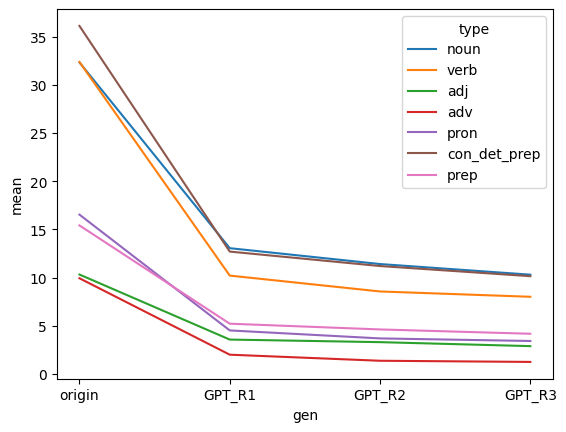

In [23]:
gpt = count_means.loc[count_means['gen'].isin(['origin','GPT_R1', 'GPT_R2','GPT_R3'])]

sns.lineplot(data=gpt, x="gen", y="mean", hue="type")

### 1.7. Statistical Test for Ratios

In [31]:
#!pip3 install statsmodels
#Because the values are proportions, I conducted a z-test analysis 

#Nouns
ztest(x1=count_ratio.Retell_1_noun_ratio, x2=count_ratio.GPT_1_noun_ratio, value=0) #significant
ztest(x1=count_ratio.Retell_2_noun_ratio, x2=count_ratio.GPT_2_noun_ratio, value=0) #significant
ztest(x1=count_ratio.Retell_3_noun_ratio, x2=count_ratio.GPT_3_noun_ratio, value=0) #significant

#Verbs
ztest(x1=count_ratio.Retell_1_verb_ratio, x2=count_ratio.GPT_1_verb_ratio, value=0) #significant
ztest(x1=count_ratio.Retell_2_verb_ratio, x2=count_ratio.GPT_2_verb_ratio, value=0) #significant
ztest(x1=count_ratio.Retell_3_verb_ratio, x2=count_ratio.GPT_3_verb_ratio, value=0) #significant

#Adj
ztest(x1=count_ratio.Retell_1_adj_ratio, x2=count_ratio.GPT_1_adj_ratio, value=0) 
ztest(x1=count_ratio.Retell_2_adj_ratio, x2=count_ratio.GPT_2_adj_ratio, value=0) #significant
ztest(x1=count_ratio.Retell_3_adj_ratio, x2=count_ratio.GPT_3_adj_ratio, value=0) #significant

#adv
ztest(x1=count_ratio.Retell_1_adv_ratio, x2=count_ratio.GPT_1_adv_ratio, value=0) #significant
ztest(x1=count_ratio.Retell_2_adv_ratio, x2=count_ratio.GPT_2_adv_ratio, value=0) #significant
ztest(x1=count_ratio.Retell_3_adv_ratio, x2=count_ratio.GPT_3_adv_ratio, value=0) #significant

#pron
ztest(x1=count_ratio.Retell_1_pron_ratio, x2=count_ratio.GPT_1_pron_ratio, value=0) #significant
ztest(x1=count_ratio.Retell_2_pron_ratio, x2=count_ratio.GPT_2_pron_ratio, value=0) #significant
ztest(x1=count_ratio.Retell_3_pron_ratio, x2=count_ratio.GPT_3_pron_ratio, value=0) #significant

#det_con_prep
ztest(x1=count_ratio.Retell_1_con_det_prep_ratio, x2=count_ratio.GPT_1_con_det_prep_ratio, value=0) #significant
ztest(x1=count_ratio.Retell_2_con_det_prep_ratio, x2=count_ratio.GPT_2_con_det_prep_ratio, value=0) #significant
ztest(x1=count_ratio.Retell_3_con_det_prep_ratio, x2=count_ratio.GPT_3_con_det_prep_ratio, value=0)

#prep
ztest(x1=count_ratio.Retell_1_prep_ratio, x2=count_ratio.GPT_1_prep_ratio, value=0) #significant
ztest(x1=count_ratio.Retell_2_prep_ratio, x2=count_ratio.GPT_2_prep_ratio, value=0) #significant
ztest(x1=count_ratio.Retell_3_prep_ratio, x2=count_ratio.GPT_3_prep_ratio, value=0) 



(-1.0802490328715624, 0.2800312990100875)

1. Retelling 

Human > GPT : verb, adv, pronoun

GPT > Human: noun, con-det-prep, prep

2. Retelling

Human > GPT : verb, adv, pronoun

GPT > Human: noun, adj, con-det-prep, prep

3. Retelling

Human > GPT : verb, adv, pronoun

GPT > Human: noun, adj


### 1.7.1. Visualize Ratios

In [ ]:
ratio_means = pd.DataFrame()
ratio_means['mean'] = [*count_ratio.mean()]
ratio_means['gen']= ['GPT_3', 'GPT_2','GPT_1', 'Retell_1','Retell_2','Retell_3','origin','GPT_3', 'GPT_2','GPT_1', 'Retell_1','Retell_2','Retell_3','origin','GPT_3', 'GPT_2','GPT_1', 'Retell_1','Retell_2','Retell_3','origin','GPT_3', 'GPT_2','GPT_1', 'Retell_1','Retell_2','Retell_3','origin','GPT_3', 'GPT_2','GPT_1', 'Retell_1','Retell_2','Retell_3','origin','GPT_3', 'GPT_2','GPT_1', 'Retell_1','Retell_2','Retell_3','origin','GPT_3', 'GPT_2','GPT_1', 'Retell_1','Retell_2','Retell_3','origin']
ratio_means['type']= ['noun','noun','noun','noun','noun','noun','noun','verb','verb','verb','verb','verb','verb','verb','adj','adj','adj','adj','adj','adj','adj','adv','adv','adv','adv','adv','adv','adv','con_det_prep','con_det_prep','con_det_prep','con_det_prep','con_det_prep','con_det_prep','con_det_prep','pron','pron','pron','pron','pron','pron','pron','prep','prep','prep','prep','prep','prep','prep']


#### 1.7.1.1. First Gen

In [ ]:
first_gen = ratio_means.loc[ratio_means['gen'].isin(['GPT_1', 'Retell_1'])]

sns.lineplot(data=first_gen, x="type", y="mean", hue="gen").set(title='significant: all except adjectives')


#### 1.7.1.2. Second Generation


In [ ]:
second_gen = ratio_means.loc[ratio_means['gen'].isin(['GPT_2', 'Retell_2'])]

sns.lineplot(data=second_gen, x="type", y="mean", hue="gen").set(title='significant: all')


#### 1.7.1.3. Second Generation


In [ ]:
third_gen = ratio_means.loc[ratio_means['gen'].isin(['GPT_3', 'Retell_3'])]

sns.lineplot(data=third_gen, x="type", y="mean", hue="gen").set(title='significant: all except preposition, and con-det-pre')


#### 1.7.1.4. All Together

In [ ]:
sns.lineplot(data=ratio_means, x="type", y="mean", hue="gen")


In [ ]:
human = ratio_means.loc[ratio_means['gen'].isin(['origin','Retell_1', 'Retell_2','Retell_3'])]
sns.lineplot(data=human, x="gen", y="mean", hue="type")

In [ ]:
gpt = ratio_means.loc[ratio_means['gen'].isin(['origin','GPT_1', 'GPT_2','GPT_3',])]

sns.lineplot(data=gpt, x="gen", y="mean", hue="type")

### 1.8. Calculate Verb-Adv and Noun-Adj Ratios

In [ ]:
#Adverb-verb ratio
df['story_adv_to_verb_ratio']= df.tokenized_STORY_tag_adv/df.tokenized_STORY_tag_verb
df['Retell_1_adv_to_verb_ratio']= df.tokenized_Retell_1_tag_adv/df.tokenized_Retell_1_tag_verb
df['Retell_2_adv_to_verb_ratio']= df.tokenized_Retell_2_tag_adv/df.tokenized_Retell_2_tag_verb
df['Retell_3_adv_to_verb_ratio']= df.tokenized_Retell_3_tag_adv/df.tokenized_Retell_3_tag_verb
df['GPT_1_adv_to_verb_ratio']= df.tokenized_GPT_R1_tag_adv/df.tokenized_GPT_R1_tag_verb
df['GPT_2_adv_to_verb_ratio']= df.tokenized_GPT_R2_tag_adv/df.tokenized_GPT_R2_tag_verb
df['GPT_3_adv_to_verb_ratio']= df.tokenized_GPT_R3_tag_adv/df.tokenized_GPT_R3_tag_verb

#Adjective-noun ratio
df['story_adj_to_noun_ratio']= df.tokenized_STORY_tag_adj/df.tokenized_STORY_tag_noun
df['Retell_1_adj_to_noun_ratio']= df.tokenized_Retell_1_tag_adj/df.tokenized_Retell_1_tag_noun
df['Retell_2_adj_to_noun_ratio']= df.tokenized_Retell_2_tag_adj/df.tokenized_Retell_2_tag_noun
df['Retell_3_adj_to_noun_ratio']= df.tokenized_Retell_3_tag_adj/df.tokenized_Retell_3_tag_noun
df['GPT_1_adj_to_noun_ratio']= df.tokenized_GPT_R1_tag_adj/df.tokenized_GPT_R1_tag_noun
df['GPT_2_adj_to_noun_ratio']= df.tokenized_GPT_R2_tag_adj/df.tokenized_GPT_R2_tag_noun
df['GPT_3_adj_to_noun_ratio']= df.tokenized_GPT_R3_tag_adj/df.tokenized_GPT_R3_tag_noun

### 1.8.2. Visualize Adb/Verb Adj/Noun Ratios


#### 1.8.2.1. Prepare dataset to visualize

In [ ]:
verbnoun_ratio = df[['story_adv_to_verb_ratio',
 'Retell_1_adv_to_verb_ratio',
 'Retell_2_adv_to_verb_ratio',
 'Retell_3_adv_to_verb_ratio',
 'GPT_1_adv_to_verb_ratio',
 'GPT_2_adv_to_verb_ratio',
 'GPT_3_adv_to_verb_ratio',
 'story_adj_to_noun_ratio',
 'Retell_1_adj_to_noun_ratio',
 'Retell_2_adj_to_noun_ratio',
 'Retell_3_adj_to_noun_ratio',
 'GPT_1_adj_to_noun_ratio',
 'GPT_2_adj_to_noun_ratio',
 'GPT_3_adj_to_noun_ratio']]

In [ ]:
verbnoun_means = pd.DataFrame()
verbnoun_means['mean'] = [*verbnoun_ratio.mean()]

In [ ]:
verbnoun_means['gen'] = ['story','first','second','third','first','second','third','story','first','second','third','first','second','third']
verbnoun_means['type'] = ['origin','human','human','human','gpt','gpt','gpt','origin','human','human','human','gpt','gpt','gpt']
verbnoun_means['ratio'] = ['adv_verb','adv_verb','adv_verb','adv_verb','adv_verb','adv_verb','adv_verb','adj_noun','adj_noun','adj_noun','adj_noun','adj_noun','adj_noun','adj_noun']


In [ ]:
# Adverb to Verb
verbnoun = verbnoun_means.loc[verbnoun_means['type'].isin(['human','gpt']) & verbnoun_means['ratio'].isin(['adv_verb']) ]

sns.lineplot(data=verbnoun, x="gen", y="mean", hue="type").set(title='Adverb to Verb Ratio (Significant All)')


In [ ]:
# Adjective to Noun 
verbnoun = verbnoun_means.loc[verbnoun_means['type'].isin(['human','gpt']) & verbnoun_means['ratio'].isin(['adj_noun']) ]

sns.lineplot(data=verbnoun, x="gen", y="mean", hue="type").set(title='Adjective to Noun Ratio (Significant at First)')


### 1.8.1. Statistical Test for Adv/verb Adj/noun ratios

In [ ]:
#Adverb to verb
ztest(x1=df.Retell_1_adv_to_verb_ratio, x2=df.GPT_1_adv_to_verb_ratio, value=0) #significant
ztest(x1=df.Retell_2_adv_to_verb_ratio, x2=df.GPT_2_adv_to_verb_ratio, value=0) #significant
ztest(x1=df.Retell_3_adv_to_verb_ratio, x2=df.GPT_3_adv_to_verb_ratio, value=0) #significant

#Adjective to noun
ztest(x1=df.Retell_1_adj_to_noun_ratio, x2=df.GPT_1_adj_to_noun_ratio, value=0) #significant
ztest(x1=df.Retell_2_adj_to_noun_ratio, x2=df.GPT_2_adj_to_noun_ratio, value=0) 
ztest(x1=df.Retell_3_adj_to_noun_ratio, x2=df.GPT_3_adj_to_noun_ratio, value=0) 

Adv/verb:


Retell 1 human mean =  0.29, gpt = 0.20 #significant

Retell 2 human mean =  0.28, gpt = 0.16 #significant

Retell 3 human mean =  0.27, gpt = 0.15 #significant

Adj/noun



Retell 1 human mean =  0.36, gpt = 0.28 #significant

Retell 2 human mean =  0.30, gpt = 0.31

Retell 3 human mean =  0.28, gpt = 0.30


## 2. Pos-Tagging for Overall

This time all taggings are summed together regardless of their story

### 2.1. Preprocess, Tag, Flatten

In [ ]:
def small_post_tagger(dataframe):
    from nltk.tokenize import word_tokenize, sent_tokenize
   # stop_words = set(stopwords.words('english'))

    story_part_tags = []
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''

    for text in dataframe:
        for ele in text:
            if ele in punc:
                text = text.replace(ele, "")

        tokenized = word_tokenize(text)
        for i in tokenized:

            # Word tokenizers is used to find the words
            # and punctuation in a string
            wordsList = nltk.word_tokenize(i)

            # removing stop words from wordList
            wordsList = [w for w in wordsList] #if not w in stop_words]

            #  Using a Tagger. Which is part-of-speech
            # tagger or POS-tagger.
            tagged = nltk.pos_tag(wordsList)

            story_part_tags.append(tagged)
    return story_part_tags

In [ ]:
# Tag small 
story_part_tags_short = small_post_tagger(df['STORY'])
Retell_1_tags_short = small_post_tagger(df['Retell_1'])
Retell_2_tags_short = small_post_tagger(df['Retell_2'])
Retell_3_tags_short = small_post_tagger(df['Retell_3'])
GPT_R1_tags_short = small_post_tagger(df['GPT_R1'])
GPT_R2_tags_short = small_post_tagger(df['GPT_R2'])
GPT_R3_tags_short = small_post_tagger(df['GPT_R3'])


In [ ]:
#Flatten 
story_part_tags_short = [item for sublist in story_part_tags_short for item in sublist]
Retell_1_tags_short = [item for sublist in Retell_1_tags_short for item in sublist]
Retell_2_tags_short = [item for sublist in Retell_2_tags_short for item in sublist]
Retell_3_tags_short = [item for sublist in Retell_3_tags_short for item in sublist]
GPT_R1_tags_short = [item for sublist in GPT_R1_tags_short for item in sublist]
GPT_R2_tags_short = [item for sublist in GPT_R2_tags_short for item in sublist]
GPT_R3_tags_short = [item for sublist in GPT_R3_tags_short for item in sublist]

### 2.2. Count Tags

In [ ]:
def count_tags(mydata):
    counter_list=[]
    for i in mydata:
        counter_list.append(i[1])

    tag_counts = Counter(counter_list) 
    return tag_counts

In [ ]:
# Short tags

story_part_tags_short = count_tags(story_part_tags_short)
GPT_R1_tag_counts_short = count_tags(GPT_R1_tags_short)
GPT_R2_tag_counts_short = count_tags(GPT_R2_tags_short)
GPT_R3_tag_counts_short = count_tags(GPT_R3_tags_short)

Retell_1_tag_counts_short = count_tags(Retell_1_tags_short)
Retell_2_tag_counts_short = count_tags(Retell_2_tags_short)
Retell_3_tag_counts_short = count_tags(Retell_3_tags_short)

### Tags:

CC: It is the conjunction of coordinating

CD: It is a digit of cardinal

DT: It is the determiner

EX: Existential

FW: It is a foreign word

IN: Preposition and conjunction

JJ: Adjective

JJR and JJS: Adjective and superlative

LS: List marker

MD: Modal

NN: Singular noun

NNS, NNP, NNPS: Proper and plural noun

PDT: Predeterminer

WRB: Adverb of wh

WP$: Possessive wh

WP: Pronoun of wh

WDT: Determiner of wp
VBZ: Verb

VBP, VBN, VBG, VBD, VB: Forms of verbs

UH: Interjection


TO: To go

RP: Particle

RBS, RB, RBR: Adverb

PRP, PRP$: Pronoun personal and professional

### 2.3. Visualize

#### 2.3.1. First Retelling

In [2]:
#Human retellings
keys = Retell_1_tag_counts_short.keys()
plt.bar(keys, Retell_1_tag_counts_short.values(), color='orange', label='Human')

#GPT retellings 
keysgpt=GPT_R1_tag_counts_short.keys()
plt.bar(keysgpt, GPT_R1_tag_counts_short.values(),color='blue', label ='chatGPT',alpha = .5)
plt.xticks(rotation=45)  #rotate x labels prevent the overlap
plt.legend(loc='upper right')
plt.title('Comparison of First Retelling')
plt.show()


NameError: name 'Retell_1_tag_counts_short' is not defined

#### 2.3.2. Second Retelling

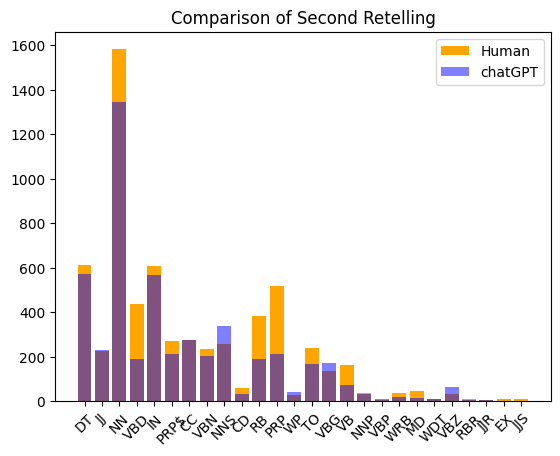

In [99]:
#Human retellings
keys = Retell_2_tag_counts_short.keys()
plt.bar(keys, Retell_2_tag_counts_short.values(), color='orange', label='Human')

#GPT retellings 
keysgpt=GPT_R2_tag_counts_short.keys()
plt.bar(keysgpt, GPT_R2_tag_counts_short.values(),color='blue', label ='chatGPT',alpha = .5)
plt.xticks(rotation=45)  #rotate x labels prevent the overlap
plt.legend(loc='upper right')
plt.title('Comparison of Second Retelling')
plt.show()

#### 2.3.3. Third Retelling

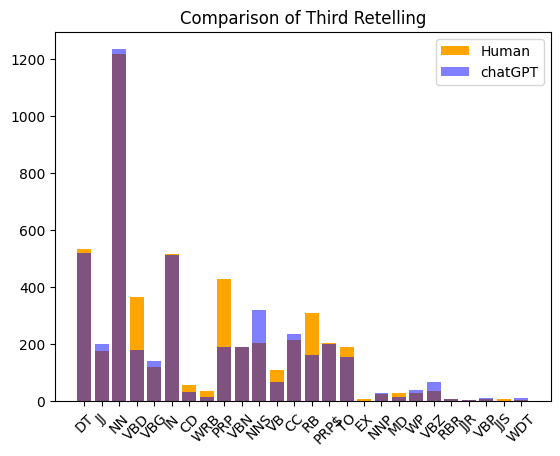

In [100]:
#Human retellings
keys = Retell_3_tag_counts_short.keys()
plt.bar(keys, Retell_3_tag_counts_short.values(), color='orange', label='Human')

#GPT retellings 
keysgpt=GPT_R3_tag_counts_short.keys()
plt.bar(keysgpt, GPT_R3_tag_counts_short.values(),color='blue', label ='chatGPT',alpha = .5)
plt.xticks(rotation=45)  #rotate x labels prevent the overlap
plt.legend(loc='upper right')
plt.title('Comparison of Third Retelling')
plt.show()

## 3. Pos-tagging for Less Category

Only noun,verb,adj,adv,pronoun, and conj/deter/prepositions

### 3.1. Change data format

In [101]:
#Change data format
origin = pd.DataFrame.from_dict(story_part_tags_short,orient='index').reset_index()
origin.columns = ['pos', 'origin']

rt1 = pd.DataFrame.from_dict(Retell_1_tag_counts_short,orient='index').reset_index()
rt1.columns = ['pos', 'rt1']

rt2 = pd.DataFrame.from_dict(Retell_2_tag_counts_short,orient='index').reset_index()
rt2.columns = ['pos', 'rt2']

rt3 = pd.DataFrame.from_dict(Retell_3_tag_counts_short,orient='index').reset_index()
rt3.columns = ['pos', 'rt3']

gpt1 = pd.DataFrame.from_dict(GPT_R1_tag_counts_short,orient='index').reset_index()
gpt1.columns = ['pos', 'gpt1']

gpt2 = pd.DataFrame.from_dict(GPT_R2_tag_counts_short,orient='index').reset_index()
gpt2.columns = ['pos', 'gpt2']

gpt3 = pd.DataFrame.from_dict(GPT_R3_tag_counts_short,orient='index').reset_index()
gpt3.columns = ['pos', 'gpt3']


In [102]:
import functools as ft

#merge dfs
dfs = [origin,rt1,rt2,rt3,gpt1,gpt2,gpt3]
df_final = ft.reduce(lambda left, right: pd.merge(left, right, on='pos',how='outer'), dfs)

#if a category is missing replace with zero
df_final.fillna(0, inplace=True)

#change floats to integer
df_final = df_final.astype({'rt1': int, 'rt2':int, 'rt3':int, 'origin':int, 'gpt1':int, 'gpt2':int, 'gpt3':int})


### 3.2. Merge relevant groups 

In [104]:
pivot = pd.pivot_table(df_final,index='pos', aggfunc=np.sum).transpose()
pivot.columns

Index(['CC', 'CD', 'DT', 'EX', 'IN', 'JJ', 'JJR', 'JJS', 'MD', 'NN', 'NNP',
       'NNS', 'PRP', 'PRP$', 'RB', 'RBR', 'TO', 'UH', 'VB', 'VBD', 'VBG',
       'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB'],
      dtype='object', name='pos')

In [140]:
pivot['NUMBERS'] = pivot['CD']

In [141]:
pivot 

pos,CC,CD,DT,EX,IN,JJ,JJR,JJS,MD,NN,...,WP$,WRB,VERBS,NOUNS,ADJECTIVES,ADVERBS,PRONOUN,CONJUNCTIONS_DETERMINERS_PREPOSITIONS,PREPOSITION,NUMBERS
gpt1,343,50,661,0,631,238,5,8,26,1570,...,0,17,860,1980,251,277,555,1492,631,50
gpt2,276,35,572,1,569,231,6,4,16,1346,...,0,19,724,1717,241,217,466,1321,569,35
gpt3,235,33,518,0,513,202,4,2,16,1232,...,0,16,662,1580,208,186,435,1197,513,33
origin,807,155,1694,19,1888,682,18,43,201,4037,...,1,114,2689,4960,743,1324,2265,4229,1888,155
rt1,404,91,817,13,828,333,9,14,79,2079,...,0,53,1410,2492,356,605,1139,1979,828,91
rt2,278,61,612,9,611,228,6,10,46,1582,...,0,39,1018,1874,244,432,818,1484,611,61
rt3,215,57,533,8,516,178,4,7,31,1216,...,0,36,829,1445,189,356,660,1250,516,57


In [123]:
pivot['VERBS'] = pivot['VB'] + pivot['VBN'] + pivot['VBG']+pivot['VBZ'] + pivot['VBP'] +pivot['VBD']
pivot['NOUNS'] = pivot['NN'] + pivot['NNS'] + pivot['NNP']#+ pivot['NNPS']
pivot['ADJECTIVES'] = pivot['JJ'] + pivot['JJS'] + pivot['JJR']
pivot['ADVERBS'] = pivot['RB'] + pivot['RBR'] + pivot['WRB']
pivot['PRONOUN'] = pivot['PRP'] + pivot['PRP$'] + pivot['WP']+pivot['WP$']
pivot['PREPOSITION'] = pivot['IN'] 
pivot['CONJUNCTIONS_DETERMINERS_PREPOSITIONS'] =pivot['DT'] + pivot['IN'] + pivot['UH']+pivot['TO']+pivot['WDT']+pivot['EX']

In [149]:
pivot_short = pivot[['VERBS','NOUNS','ADJECTIVES','ADVERBS','PRONOUN','PREPOSITION','CONJUNCTIONS_DETERMINERS_PREPOSITIONS','NUMBERS']].reset_index()

In [150]:
pivot_short

pos,index,VERBS,NOUNS,ADJECTIVES,ADVERBS,PRONOUN,PREPOSITION,CONJUNCTIONS_DETERMINERS_PREPOSITIONS,NUMBERS
0,gpt1,860,1980,251,277,555,631,1492,50
1,gpt2,724,1717,241,217,466,569,1321,35
2,gpt3,662,1580,208,186,435,513,1197,33
3,origin,2689,4960,743,1324,2265,1888,4229,155
4,rt1,1410,2492,356,605,1139,828,1979,91
5,rt2,1018,1874,244,432,818,611,1484,61
6,rt3,829,1445,189,356,660,516,1250,57


In [151]:
Human = pivot_short[(pivot_short['index']=='origin') | (pivot_short['index']=='rt1') |( pivot_short['index']=='rt2')| (pivot_short['index']=='rt3')]
GPT = pivot_short[(pivot_short['index']=='origin') | (pivot_short['index']=='gpt1') |( pivot_short['index']=='gpt2')| (pivot_short['index']=='gpt3')]
   

In [152]:
Human

pos,index,VERBS,NOUNS,ADJECTIVES,ADVERBS,PRONOUN,PREPOSITION,CONJUNCTIONS_DETERMINERS_PREPOSITIONS,NUMBERS
3,origin,2689,4960,743,1324,2265,1888,4229,155
4,rt1,1410,2492,356,605,1139,828,1979,91
5,rt2,1018,1874,244,432,818,611,1484,61
6,rt3,829,1445,189,356,660,516,1250,57


In [153]:
GPT

pos,index,VERBS,NOUNS,ADJECTIVES,ADVERBS,PRONOUN,PREPOSITION,CONJUNCTIONS_DETERMINERS_PREPOSITIONS,NUMBERS
0,gpt1,860,1980,251,277,555,631,1492,50
1,gpt2,724,1717,241,217,466,569,1321,35
2,gpt3,662,1580,208,186,435,513,1197,33
3,origin,2689,4960,743,1324,2265,1888,4229,155


In [154]:
GPT = GPT.set_index(['index']).reindex(["origin","gpt1","gpt2","gpt3"]).reset_index()

In [155]:
Human.columns =['GENERATION', 'VERBS', 'NOUNS', 'ADJECTIVES', 'ADVERBS', 'PRONOUN','PREPOSITION',
       'CONJUNCTIONS_DETERMINERS_PREPOSITIONS','NUMBERS']
GPT.columns =['GENERATION', 'VERBS', 'NOUNS', 'ADJECTIVES', 'ADVERBS', 'PRONOUN','PREPOSITION',
       'CONJUNCTIONS_DETERMINERS_PREPOSITIONS','NUMBERS']

### 3.3. Visualize

<function matplotlib.pyplot.show(close=None, block=None)>

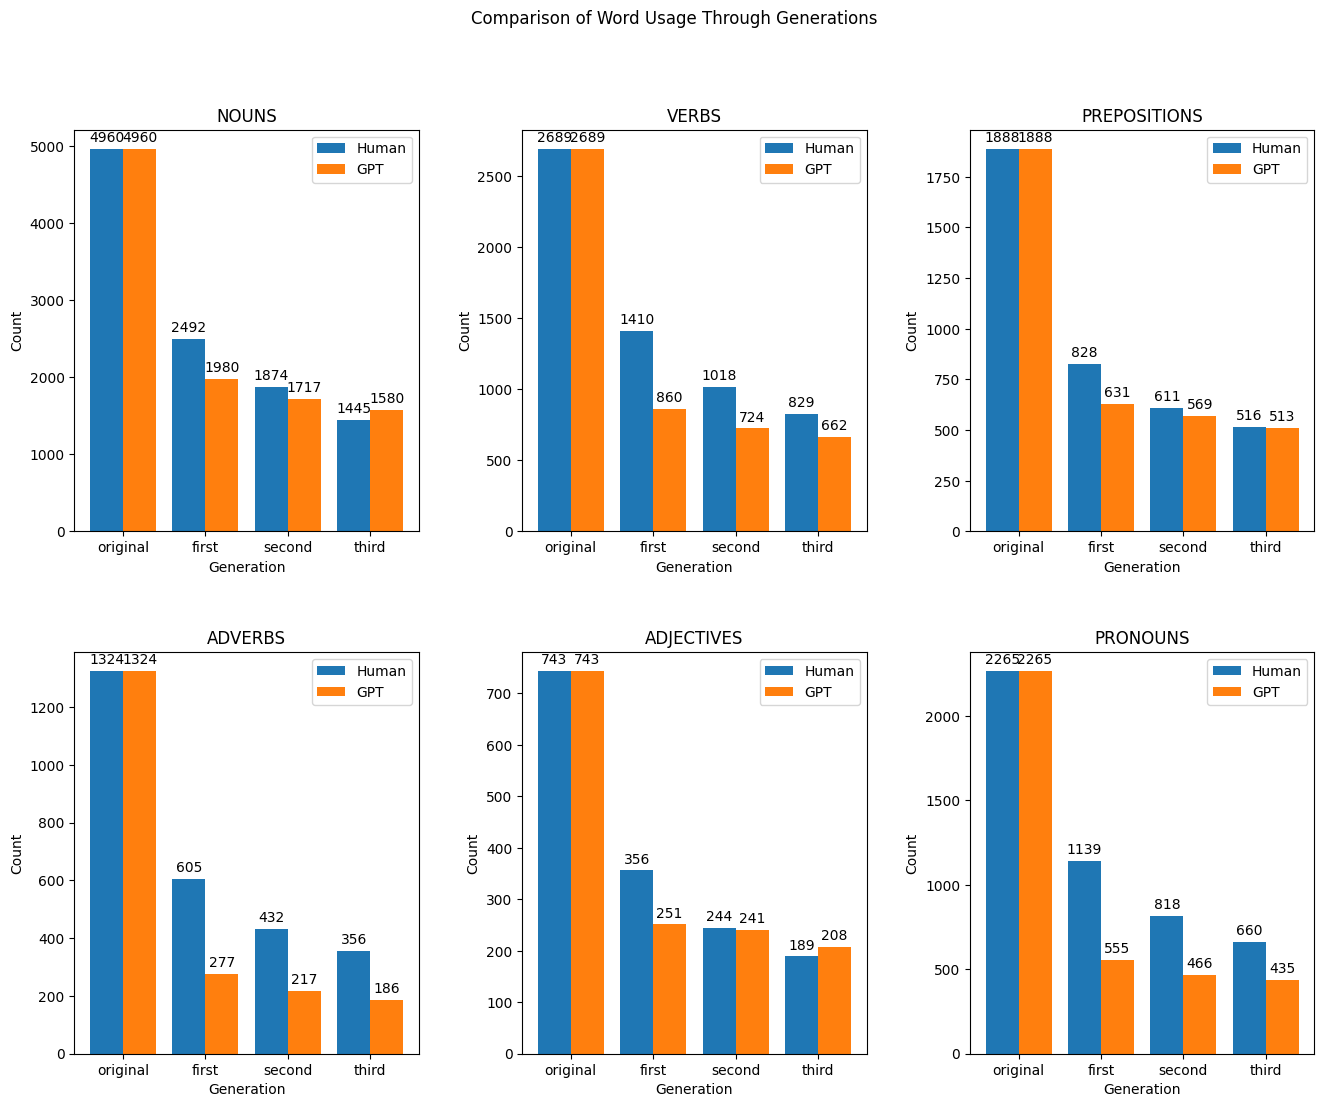

In [139]:
# Create some data
x = ['original', 'first','second','third']
y1 = Human['NOUNS']
y2 = GPT['NOUNS']

# Set the width of each bar
bar_width = 0.40

# Create the bar plot
fig, axs = plt.subplots(2, 3)
rects1 = axs[0,0].bar(x, y1, bar_width, label='Human')
rects2 = axs[0,0].bar([i + bar_width for i in range(len(x))], y2, bar_width, label='GPT')

# Add labels and a legend
axs[0,0].set_xlabel('Generation')
axs[0,0].set_ylabel('Count')
axs[0,0].set_title('NOUNS')
axs[0,0].set_xticks([i + bar_width/2 for i in range(len(x))])
axs[0,0].set_xticklabels(x)
axs[0,0].legend()

# Add text on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        axs[0,0].annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Create some data
x = ['original', 'first','second','third']
y1 = Human['VERBS']
y2 = GPT['VERBS']

# Set the width of each bar
bar_width = 0.40

# Create the bar plot
rects1 = axs[0,1].bar(x, y1, bar_width, label='Human')
rects2 = axs[0,1].bar([i + bar_width for i in range(len(x))], y2, bar_width, label='GPT')

# Add labels and a legend
axs[0,1].set_xlabel('Generation')
axs[0,1].set_ylabel('Count')
axs[0,1].set_title('VERBS')
axs[0,1].set_xticks([i + bar_width/2 for i in range(len(x))])
axs[0,1].set_xticklabels(x)
axs[0,1].legend()

# Add text on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        axs[0,1].annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)



# Create some data
x = ['original', 'first','second','third']
y1 = Human['ADJECTIVES']
y2 = GPT['ADJECTIVES']

# Set the width of each bar
bar_width = 0.40

# Create the bar plot
rects1 = axs[1,1].bar(x, y1, bar_width, label='Human')
rects2 = axs[1,1].bar([i + bar_width for i in range(len(x))], y2, bar_width, label='GPT')

# Add labels and a legend
axs[1,1].set_xlabel('Generation')
axs[1,1].set_ylabel('Count')
axs[1,1].set_title('ADJECTIVES')
axs[1,1].set_xticks([i + bar_width/2 for i in range(len(x))])
axs[1,1].set_xticklabels(x)
axs[1,1].legend()

# Add text on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        axs[1,1].annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Create some data
x = ['original', 'first','second','third']
y1 = Human['ADVERBS']
y2 = GPT['ADVERBS']

# Set the width of each bar
bar_width = 0.40

# Create the bar plot
rects1 = axs[1,0].bar(x, y1, bar_width, label='Human')
rects2 = axs[1,0].bar([i + bar_width for i in range(len(x))], y2, bar_width, label='GPT')

# Add labels and a legend
axs[1,0].set_xlabel('Generation')
axs[1,0].set_ylabel('Count')
axs[1,0].set_title('ADVERBS')
axs[1,0].set_xticks([i + bar_width/2 for i in range(len(x))])
axs[1,0].set_xticklabels(x)
axs[1,0].legend()

# Add text on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        axs[1,0].annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.set_size_inches(16, 12)

plt.subplots_adjust(wspace=0.3, hspace=0.3)
fig.suptitle('Comparison of Word Usage Through Generations')

# prepositions
x = ['original', 'first','second','third']
y1 = Human['PREPOSITION']
y2 = GPT['PREPOSITION']

# Set the width of each bar
bar_width = 0.40

# Create the bar plot
rects1 = axs[0,2].bar(x, y1, bar_width, label='Human')
rects2 = axs[0,2].bar([i + bar_width for i in range(len(x))], y2, bar_width, label='GPT')

# Add labels and a legend
axs[0,2].set_xlabel('Generation')
axs[0,2].set_ylabel('Count')
axs[0,2].set_title('PREPOSITIONS')
axs[0,2].set_xticks([i + bar_width/2 for i in range(len(x))])
axs[0,2].set_xticklabels(x)
axs[0,2].legend()

# Add text on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        axs[0,2].annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)


# pronouns
x = ['original', 'first','second','third']
y1 = Human['PRONOUN']
y2 = GPT['PRONOUN']

# Set the width of each bar
bar_width = 0.40

# Create the bar plot
rects1 = axs[1,2].bar(x, y1, bar_width, label='Human')
rects2 = axs[1,2].bar([i + bar_width for i in range(len(x))], y2, bar_width, label='GPT')

# Add labels and a legend
axs[1,2].set_xlabel('Generation')
axs[1,2].set_ylabel('Count')
axs[1,2].set_title('PRONOUNS')
axs[1,2].set_xticks([i + bar_width/2 for i in range(len(x))])
axs[1,2].set_xticklabels(x)
axs[1,2].legend()

# Add text on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        axs[1,2].annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Show the plot
plt.show


## 3.4. Visualize Numbers

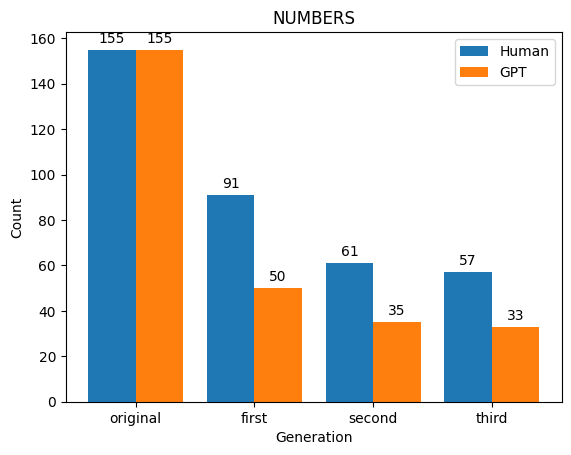

In [188]:
x = ['original', 'first','second','third']
y1 = Human['NUMBERS']
y2 = GPT['NUMBERS']

fig, ax = plt.subplots()



# Create the bar plot
rects1 = ax.bar(x, y1, bar_width, label='Human')
rects2 = ax.bar([i + bar_width for i in range(len(x))], y2, bar_width, label='GPT')

# Add labels and a legend
ax.set_xlabel('Generation')
ax.set_ylabel('Count')
ax.set_title('NUMBERS')
ax.set_xticks([i + bar_width/2 for i in range(len(x))])
ax.set_xticklabels(x)
ax.legend()

# Add text on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

